In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [2]:
# Define the path to your Excel file
file_path = "/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250328/H2O refractive index.xlsx"
file_path2 = "/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250604/Au refractive index.xlsx"

# Read the Excel file
df_full = pd.read_excel(file_path, engine='openpyxl', nrows=168)
df_full2 = pd.read_excel(file_path2, engine='openpyxl', nrows=447)

# Extract the 2nd, 3rd, and 4th columns (indexing starts from 0)
water_nk = df_full.iloc[:, [1, 2, 3]]
Au_nk = df_full2.iloc[:, [1, 2, 3]]

# Rename the columns for clarity
water_nk.columns = ["Wavenumber (cm⁻¹)", "n (real)", "k (imag)"]
Au_nk.columns = ["Wavenumber (cm⁻¹)", "n (real)", "k (imag)"]

In [3]:
# Extract x and y from gold data
Au_wavenumbers = Au_nk["Wavenumber (cm⁻¹)"].values
Au_n = Au_nk["n (real)"].values
Au_k = Au_nk["k (imag)"].values

# Reference wavenumbers from water
target_wavenumbers = water_nk["Wavenumber (cm⁻¹)"].values

# Create interpolation functions with extrapolation enabled
interp_n_func = interp1d(Au_wavenumbers, Au_n, kind='linear', fill_value="extrapolate")
interp_k_func = interp1d(Au_wavenumbers, Au_k, kind='linear', fill_value="extrapolate")

# Evaluate interpolated (or extrapolated) values at water wavenumbers
interp_n = interp_n_func(target_wavenumbers)
interp_k = interp_k_func(target_wavenumbers)

# Create new DataFrame with interpolated gold data
Au_interp = pd.DataFrame({
    "Wavenumber (cm⁻¹)": target_wavenumbers,
    "n (real)": interp_n,
    "k (imag)": interp_k
})

# Merge water and gold refractive index data on wavenumber
merged_nk = pd.merge(
    water_nk,
    Au_interp,
    on="Wavenumber (cm⁻¹)",
    suffixes=("_water", "_Au")
)

——————————————————————————————————Obtained dataframe of refractive indices————————————————————————————————————————————

In [4]:
# Function to calculate reflectance for 3-layer system

def three_layer_reflectance(n0, n1, n2, d1, wavelength, theta0_deg, pol='s'):
    n0 = complex(n0)
    n1 = complex(n1)
    n2 = complex(n2)

    theta0_rad = np.radians(theta0_deg)

    sin_theta1 = (n0 / n1) * np.sin(theta0_rad)
    theta1 = np.arcsin(sin_theta1) 

    sin_theta2 = (n0 / n2) * np.sin(theta0_rad)
    theta2 = np.arcsin(sin_theta2)  

    def fresnel(n_i, n_j, theta_i, theta_j, pol):
        if pol == 's':
            return (n_i * np.cos(theta_i) - n_j * np.cos(theta_j)) / (n_i * np.cos(theta_i) + n_j * np.cos(theta_j))
        elif pol == 'p':
            return (n_j * np.cos(theta_i) - n_i * np.cos(theta_j)) / (n_j * np.cos(theta_i) + n_i * np.cos(theta_j))
        else:
            raise ValueError("Polarization must be 's' or 'p'")

    r01 = fresnel(n0, n1, theta0_rad, theta1, pol)
    r12 = fresnel(n1, n2, theta1, theta2, pol)
    delta = (2 * np.pi / wavelength) * n1 * d1 * np.cos(theta1)
    r_total = (r01 + r12 * np.exp(2j * delta)) / (1 + r01 * r12 * np.exp(2j * delta))
    return r_total

In [5]:
# Constants
n_Si = 3.417 + 0j  # Refractive index of Si
d_gold = 5.5e-9     # 10 nm film
n_air = 1.0 + 0j

# Arrays
wavenumbers = merged_nk["Wavenumber (cm⁻¹)"].values
wavelengths = 1e-2 / wavenumbers  # Convert cm⁻¹ to meters
n_Au = merged_nk["n (real)_Au"].values + 1j * merged_nk["k (imag)_Au"].values
n_water = merged_nk["n (real)_water"].values + 1j * merged_nk["k (imag)_water"].values

In [6]:
def compute_reflectance_ratios(theta_deg):
    r_water_s = []
    r_air_s = []
    r_water_p = []
    r_air_p = []

    R_normalized=[]
    R_air=[]
    Rs_air=[]
    Rp_air=[]
    R_water=[]
    Rs_water=[]
    Rp_water=[]

    for wavenumber, wl, n1, n2_water in zip(wavenumbers,wavelengths, n_Au, n_water):
        # Use your three_layer_reflectance() function
        r_s_water = three_layer_reflectance(n_Si, n1, n2_water, d_gold, wl, theta_deg, pol='s')
        r_s_air   = three_layer_reflectance(n_Si, n1, n_air, d_gold, wl, theta_deg, pol='s')

        r_p_water = three_layer_reflectance(n_Si, n1, n2_water, d_gold, wl, theta_deg, pol='p')
        r_p_air   = three_layer_reflectance(n_Si, n1, n_air, d_gold, wl, theta_deg, pol='p')

        r_water_s.append(r_s_water)
        r_air_s.append(r_s_air)
        r_water_p.append(r_p_water)
        r_air_p.append(r_p_air)

        R_s_air = abs(r_s_air)**2
        R_p_air = abs(r_p_air)**2 
        R_s_water = abs(r_s_water)**2
        R_p_water = abs(r_p_water)**2 

        R_air_single = (abs(r_s_air)**2 + abs(r_p_air)**2 )/2
        R_water_single = (abs(r_s_water)**2 + abs(r_p_water)**2 )/2 # Numerator

        R_ratio = R_water_single / R_air_single 

        R_normalized.append(R_ratio)
        R_air.append(R_air_single)
        Rs_air.append(R_s_air)
        Rp_air.append(R_p_air)
        R_water.append(R_water_single)
        Rs_water.append(R_s_water)
        Rp_water.append(R_p_water)


    return wavenumbers,wavelengths,r_s_water,r_air_s,r_water_p,r_air_p, R_normalized, R_water, R_air, Rs_water, Rp_water, Rs_air, Rp_air


In [7]:
# Prepare output dictionary
angle_dict = {}
angles_deg = np.concatenate([np.arange(2, 50.1, 0.1)])

# Loop over angles
for angle in angles_deg:
    wavenumbers,wavelengths,r_s_water,r_air_s,r_water_p,r_air_p, R_normalized, R_water, R_air, Rs_water, Rp_water, Rs_air, Rp_air = compute_reflectance_ratios(angle)

    df = pd.DataFrame({
        "wavenumber": wavenumbers,
        "Rnorm": R_normalized,
        "R_water": R_water,
        "Rs_water": Rs_water,
        "Rp_water": Rp_water,
        "R_air": R_air,
        "Rs_air": Rs_air,
        "Rp_air": Rp_air

    })

    angle_dict[angle] = df


——————————————————————————————————Obtained dictionary of angles vs. Refractivites————————————————————————————————————————————

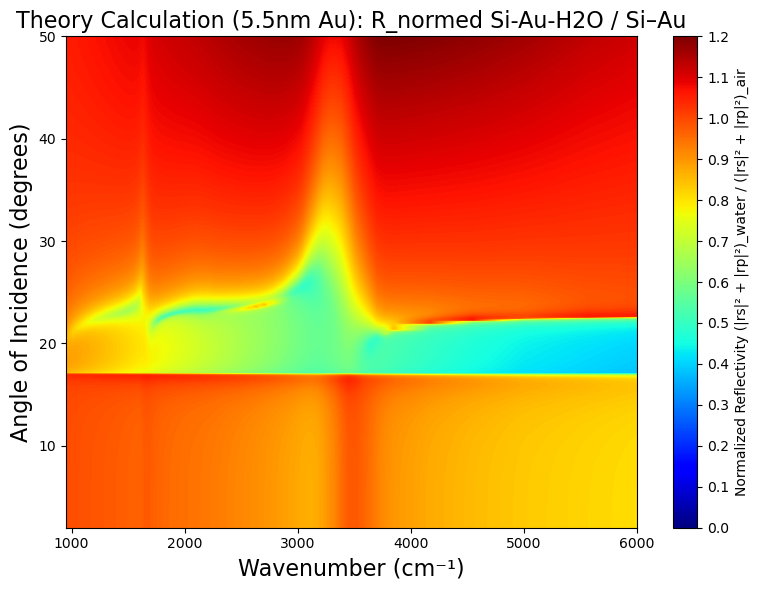

In [8]:
# Sort angles and extract wavenumbers
angles = sorted(angle_dict.keys())
wavenumbers = np.array(angle_dict[angles[0]]['wavenumber'].values)


# Create 2D matrix for Rnorm
Rnorm_matrix = np.array([angle_dict[angle]['Rnorm'].values for angle in angles])

# Meshgrid
W_grid, A_grid = np.meshgrid(wavenumbers, angles)

levels = np.linspace(0, 1.2, 256)
plt.figure(figsize=(8, 6))  
contour = plt.contourf(W_grid, A_grid, Rnorm_matrix, levels=levels, cmap='jet', extend='neither')
cbar = plt.colorbar(contour)
cbar.set_label('Normalized Reflectivity (|rs|² + |rp|²)_water / (|rs|² + |rp|²)_air')
cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4,0.5, 0.6,0.7, 0.8, 0.9,1.0,1.1, 1.2])

plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Angle of Incidence (degrees)", fontsize=16)
plt.title(f"Theory Calculation ({d_gold*1e9}nm Au): R_normed Si-Au-H2O / Si–Au", fontsize=16)
plt.xlim(950,6000)
plt.tight_layout()
plt.show()

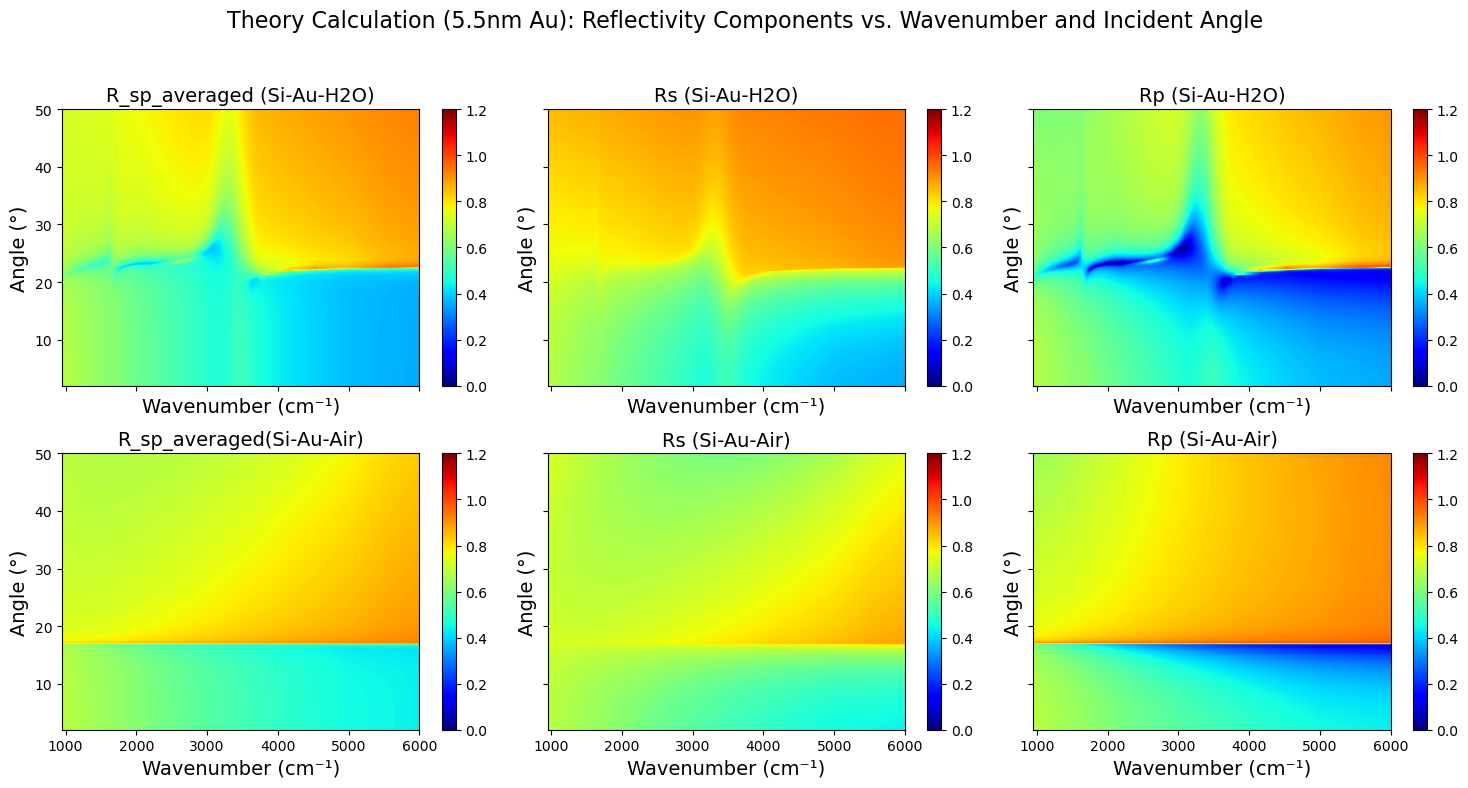

In [9]:
# Create 2D matrices for each reflectivity component
R_water_matrix   = np.array([angle_dict[angle]['R_water'].values for angle in angles])
Rs_water_matrix  = np.array([angle_dict[angle]['Rs_water'].values for angle in angles])
Rp_water_matrix  = np.array([angle_dict[angle]['Rp_water'].values for angle in angles])
R_air_matrix     = np.array([angle_dict[angle]['R_air'].values for angle in angles])
Rs_air_matrix    = np.array([angle_dict[angle]['Rs_air'].values for angle in angles])
Rp_air_matrix    = np.array([angle_dict[angle]['Rp_air'].values for angle in angles])

# --- Set consistent color levels and ticks ---
levels = np.linspace(0, 1.2, 256)
colorbar_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]

# Set up 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

# Titles and corresponding data
titles = [
    "R_sp_averaged (Si-Au-H2O)", "Rs (Si-Au-H2O)", "Rp (Si-Au-H2O)",
    "R_sp_averaged(Si-Au-Air)",   "Rs (Si-Au-Air)",   "Rp (Si-Au-Air)"
]

data_matrices = [
    R_water_matrix, Rs_water_matrix, Rp_water_matrix,
    R_air_matrix,   Rs_air_matrix,   Rp_air_matrix
]

# --- Plot each contour subplot ---
for ax, title, data in zip(axes.flat, titles, data_matrices):
    contour = ax.contourf(W_grid, A_grid, data, levels=levels, cmap='jet', extend='neither')
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_ticks(colorbar_ticks)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Wavenumber (cm⁻¹)", fontsize=14)
    ax.set_ylabel("Angle (°)", fontsize=14)
    ax.set_xlim(950,6000)

# --- Global layout ---
fig.suptitle(f"Theory Calculation ({d_gold*1e9}nm Au): Reflectivity Components vs. Wavenumber and Incident Angle", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

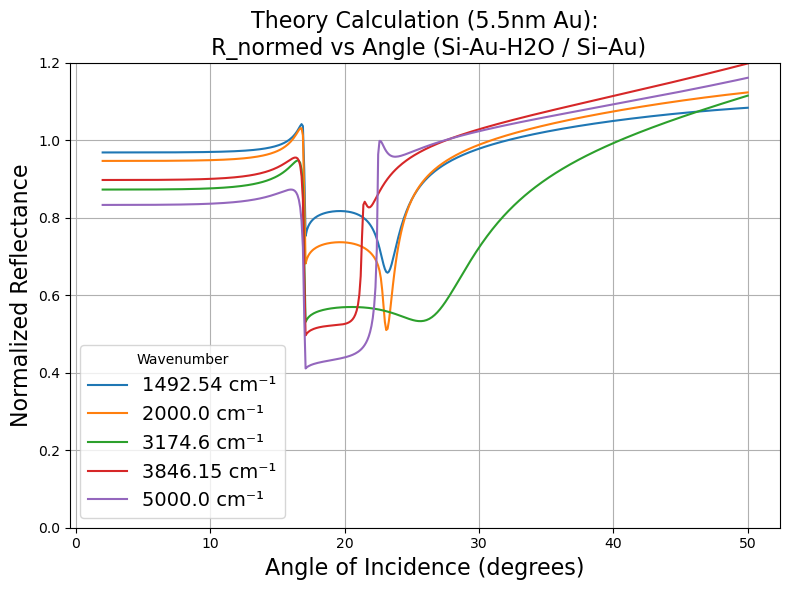

In [10]:
# Choose target wavenumbers (approximate)
target_wavenumbers = [1500, 2000,3200,4000, 5000]

# Extract sorted angle list
angles = sorted(angle_dict.keys())

# Prepare figure
plt.figure(figsize=(8, 6))

for wn_target in target_wavenumbers:
    Rnorm_values = []

    for angle in angles:
        nk_data = angle_dict[angle]
        # Find index of closest wavenumber
        idx_closest = (nk_data["wavenumber"] - wn_target).abs().idxmin()
        Rnorm = nk_data.loc[idx_closest, "Rnorm"]
        Rnorm_values.append(Rnorm)

    matched_wn = round(nk_data.loc[idx_closest, "wavenumber"], 2)
    plt.plot(angles, Rnorm_values, '-', label=f'{matched_wn} cm⁻¹')

# Customize plot
plt.title(f"Theory Calculation ({d_gold*1e9}nm Au):\n R_normed vs Angle (Si-Au-H2O / Si–Au)", fontsize=16)
plt.xlabel("Angle of Incidence (degrees)", fontsize=16)
plt.ylabel("Normalized Reflectance", fontsize=16)
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(title="Wavenumber", fontsize=14)
plt.tight_layout()
plt.show()

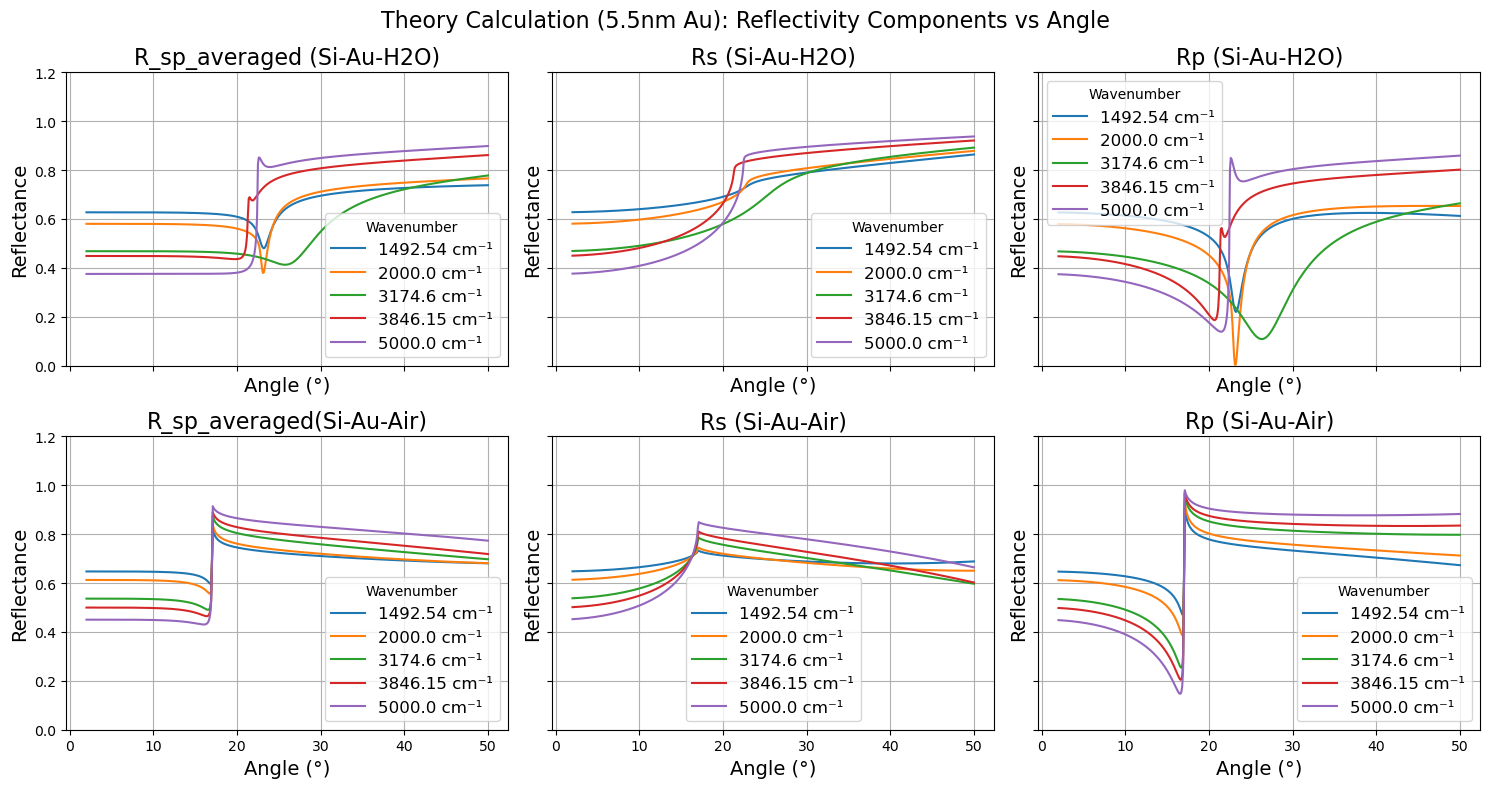

In [11]:
# Choose target wavenumbers (approximate)
target_wavenumbers = [1500, 2000, 3200, 4000, 5000]

# Extract sorted angle list
angles = sorted(angle_dict.keys())

# Reflectivity components and titles
components = ["R_water", "Rs_water", "Rp_water", "R_air", "Rs_air", "Rp_air"]
titles = [
    "R_sp_averaged (Si-Au-H2O)", "Rs (Si-Au-H2O)", "Rp (Si-Au-H2O)",
    "R_sp_averaged(Si-Au-Air)",   "Rs (Si-Au-Air)",   "Rp (Si-Au-Air)"
]

# Create 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

# Loop over subplots
for ax, comp, title in zip(axes.flat, components, titles):
    for wn_target in target_wavenumbers:
        values = []

        for angle in angles:
            nk_data = angle_dict[angle]
            idx_closest = (nk_data["wavenumber"] - wn_target).abs().idxmin()
            val = nk_data.loc[idx_closest, comp]
            values.append(val)

        matched_wn = round(nk_data.loc[idx_closest, "wavenumber"], 2)
        ax.plot(angles, values, label=f'{matched_wn} cm⁻¹')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Angle (°)", fontsize=14)
    ax.set_ylabel("Reflectance", fontsize=14)
    ax.set_ylim(0, 1.2)
    ax.grid(True)
    ax.legend(title="Wavenumber", fontsize=12)


# Global layout
fig.suptitle(f"Theory Calculation ({d_gold*1e9}nm Au): Reflectivity Components vs Angle", fontsize=16)
plt.tight_layout()
plt.show()


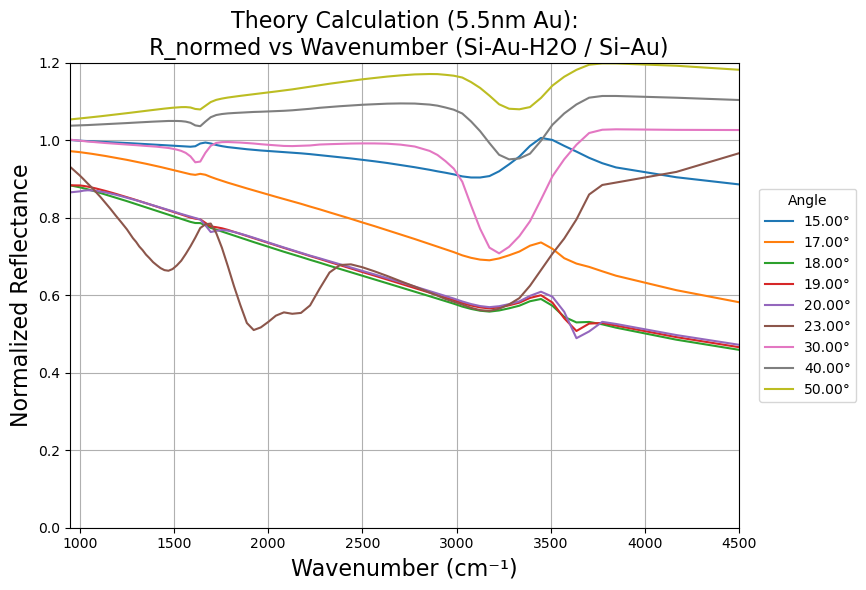

In [12]:
# Select target angles (in degrees)
target_angles = [15, 17,18, 19,20, 23, 30, 40, 50] 
#target_angles = [22.2, 22.7, 23.3, 24.4, 25.6, 33.5]
#target_angles = angles_deg 

# Get available angles from angle_dict
available_angles = np.array(sorted(angle_dict.keys()))

# Match target angles to the closest available in angle_dict
matched_angles = [available_angles[np.argmin(np.abs(available_angles - a))] for a in target_angles]

# Plot
plt.figure(figsize=(11, 6))

for angle in matched_angles:
    df = angle_dict[angle]
    wn = df["wavenumber"].values
    Rnorm = df["Rnorm"].values

    plt.plot(wn, Rnorm, label=f"{angle:.2f}°")

# Customize plot
plt.title(f"Theory Calculation ({d_gold*1e9}nm Au):\n R_normed vs Wavenumber (Si-Au-H2O / Si–Au)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectance", fontsize=16)
plt.xlim(950, 4500)
plt.ylim(0, 1.2)
plt.grid(True)

# Place legend outside
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend

plt.show()


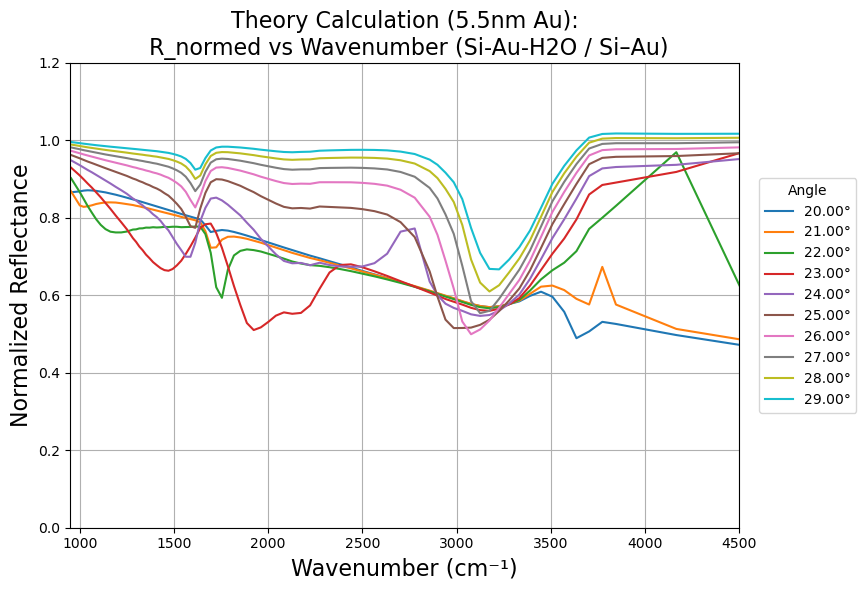

In [13]:
# Select target angles (in degrees)
target_angles = [20,21,22,23,24,25,26,27,28,29]
#target_angles = angles_deg 

# Get available angles from angle_dict
available_angles = np.array(sorted(angle_dict.keys()))

# Match target angles to the closest available in angle_dict
matched_angles = [available_angles[np.argmin(np.abs(available_angles - a))] for a in target_angles]

# Plot
plt.figure(figsize=(11, 6))

for angle in matched_angles:
    df = angle_dict[angle]
    wn = df["wavenumber"].values
    Rnorm = df["Rnorm"].values

    plt.plot(wn, Rnorm, label=f"{angle:.2f}°")

# Customize plot
plt.title(f"Theory Calculation ({d_gold*1e9}nm Au):\n R_normed vs Wavenumber (Si-Au-H2O / Si–Au)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectance", fontsize=16)
plt.xlim(950, 4500)
plt.ylim(0, 1.2)
plt.grid(True)

# Place legend outside
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend

plt.show()


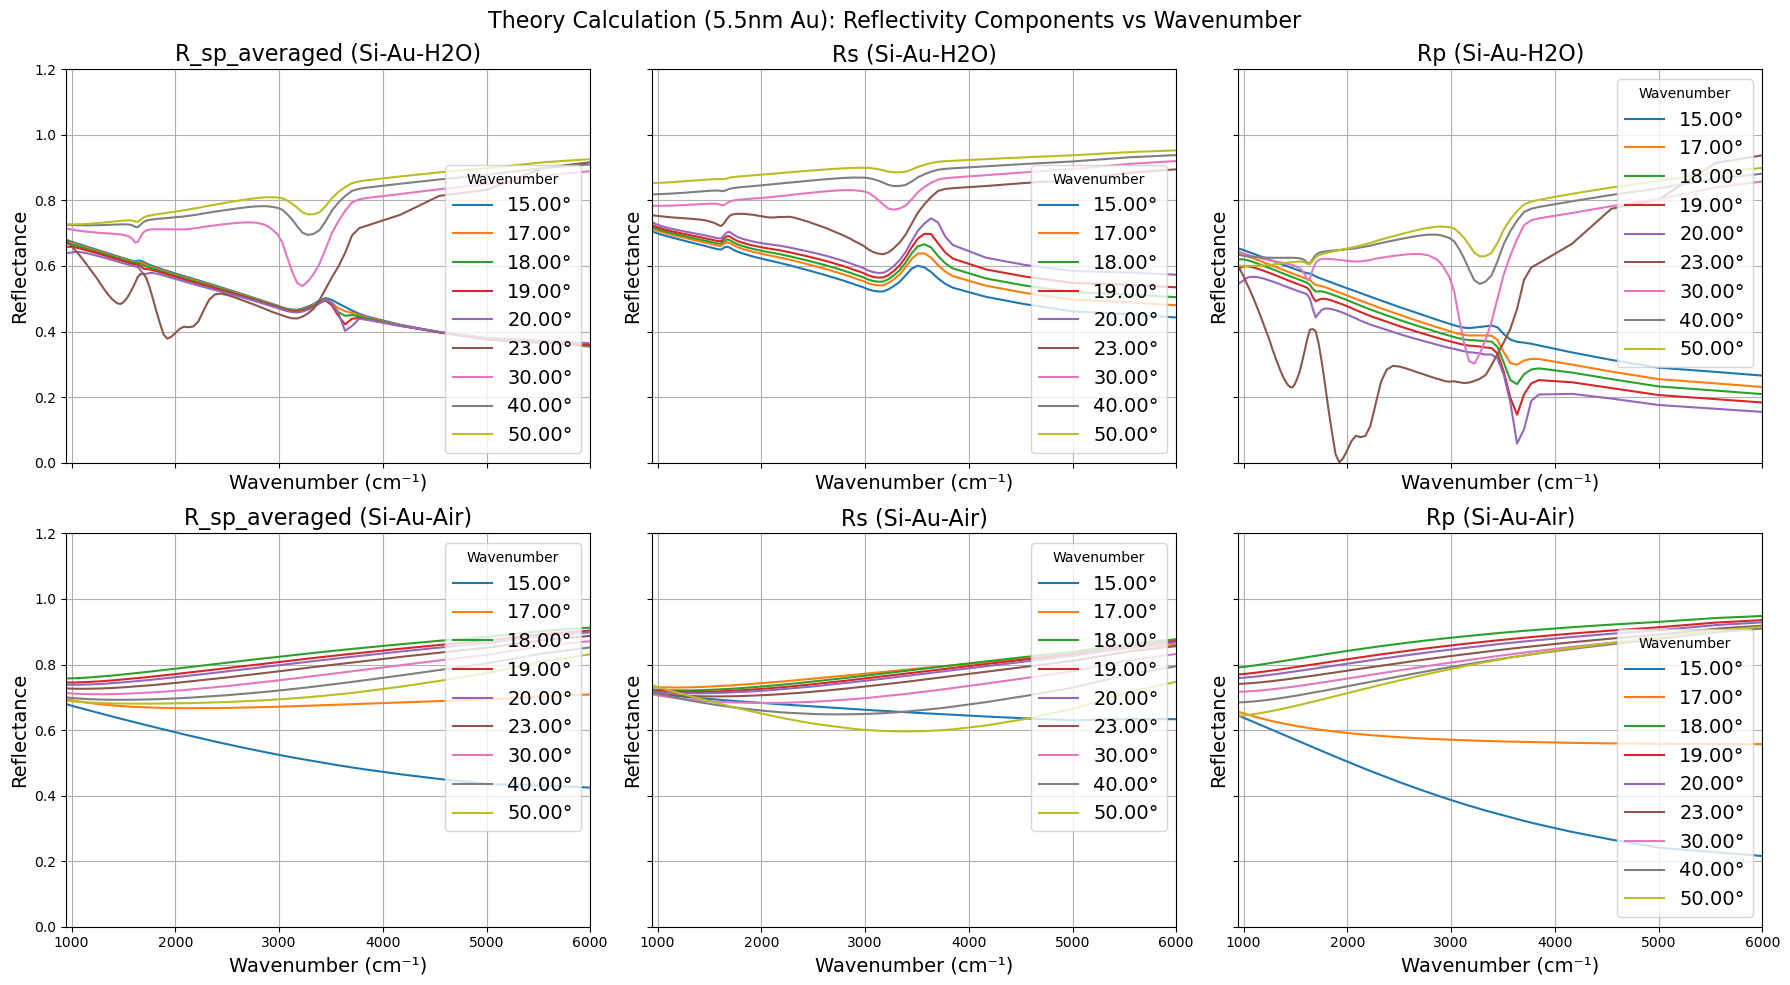

In [14]:
# Define reflectivity components and subplot titles
components = ["R_water", "Rs_water", "Rp_water", "R_air", "Rs_air", "Rp_air"]
titles = [
    "R_sp_averaged (Si-Au-H2O)", "Rs (Si-Au-H2O)", "Rp (Si-Au-H2O)",
    "R_sp_averaged (Si-Au-Air)", "Rs (Si-Au-Air)", "Rp (Si-Au-Air)"
]

# Get available angles and match to target angles
target_angles = [15, 17,18, 19,20, 23, 30, 40, 50] 
available_angles = np.array(sorted(angle_dict.keys()))
matched_angles = [available_angles[np.argmin(np.abs(available_angles - a))] for a in target_angles]

# Create 2x3 subplot figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Plot each component
for ax, comp, title in zip(axes.flat, components, titles):
    for angle in matched_angles:
        df = angle_dict[angle]
        wn = df["wavenumber"].values
        y = df[comp].values
        ax.plot(wn, y, label=f"{angle:.2f}°")

    ax.set_title(title, fontsize=16)
    ax.set_xlim(950, 6000)
    ax.set_ylim(0, 1.2)
    ax.grid(True)
    ax.set_xlabel("Wavenumber (cm⁻¹)", fontsize=14)
    ax.set_ylabel("Reflectance", fontsize=14)
    ax.legend(title="Wavenumber", fontsize=14)


# Adjust layout
fig.suptitle(f"Theory Calculation ({d_gold*1e9}nm Au): Reflectivity Components vs Wavenumber", fontsize=16)
plt.tight_layout()
plt.show()


——————————————————————————————————Sliding average over angles————————————————————————————————————————————

In [15]:
# --- Smoothing window  ---
window = 6.34


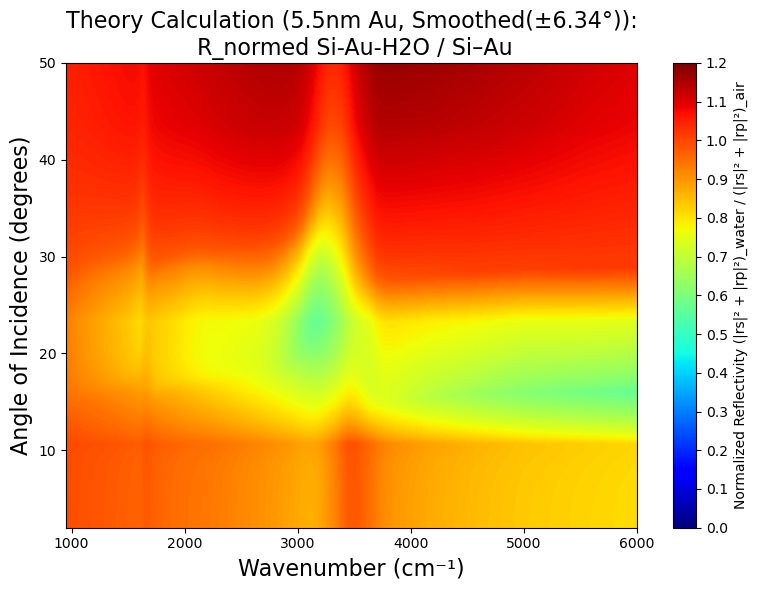

In [16]:
# --- Extract sorted angle list and wavenumbers ---
angles_all = np.array(sorted(angle_dict.keys()))
wavenumbers = np.array(angle_dict[angles_all[0]]['wavenumber'].values)



# --- Initialize smoothed component lists ---
R_water_smooth  = []
Rs_water_smooth = []
Rp_water_smooth = []
R_air_smooth    = []
Rs_air_smooth   = []
Rp_air_smooth   = []
Rnorm_smooth= []

# --- Smoothing loop ---
for angle in angles_all:
    neighbor_mask = (angles_all >= angle - window) & (angles_all <= angle + window)
    neighbor_angles = angles_all[neighbor_mask]

    # Average each component across neighbors
    R_water_avg  = np.mean([angle_dict[a]['R_water'].values for a in neighbor_angles], axis=0)
    Rs_water_avg = np.mean([angle_dict[a]['Rs_water'].values for a in neighbor_angles], axis=0)
    Rp_water_avg = np.mean([angle_dict[a]['Rp_water'].values for a in neighbor_angles], axis=0)
    R_air_avg    = np.mean([angle_dict[a]['R_air'].values for a in neighbor_angles], axis=0)
    Rs_air_avg   = np.mean([angle_dict[a]['Rs_air'].values for a in neighbor_angles], axis=0)
    Rp_air_avg   = np.mean([angle_dict[a]['Rp_air'].values for a in neighbor_angles], axis=0)
    Rnorm_avg = np.mean([angle_dict[a]['Rnorm'].values for a in neighbor_angles], axis=0)
    

    # Append to corresponding smoothed lists
    Rnorm_smooth.append(Rnorm_avg)
    R_water_smooth.append(R_water_avg)
    Rs_water_smooth.append(Rs_water_avg)
    Rp_water_smooth.append(Rp_water_avg)
    R_air_smooth.append(R_air_avg)
    Rs_air_smooth.append(Rs_air_avg)
    Rp_air_smooth.append(Rp_air_avg)

# --- Convert to arrays ---
R_water_smooth  = np.array(R_water_smooth)
Rs_water_smooth = np.array(Rs_water_smooth)
Rp_water_smooth = np.array(Rp_water_smooth)
R_air_smooth    = np.array(R_air_smooth)
Rs_air_smooth   = np.array(Rs_air_smooth)
Rp_air_smooth   = np.array(Rp_air_smooth)

Rnorm_smooth_ratio = R_water_smooth/R_air_smooth

# --- Meshgrid for plotting ---
W_grid, A_grid = np.meshgrid(wavenumbers, angles_all)
levels = np.linspace(0, 1.2, 256)

# --- Plot smoothed Rnorm ---
plt.figure(figsize=(8, 6))
contour = plt.contourf(W_grid, A_grid, Rnorm_smooth_ratio, levels=levels, cmap='jet', extend='neither')
cbar = plt.colorbar(contour)
cbar.set_label('Normalized Reflectivity (|rs|² + |rp|²)_water / (|rs|² + |rp|²)_air')
cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4,0.5, 0.6,0.7, 0.8, 0.9,1.0,1.1, 1.2])

plt.title(f"Theory Calculation ({d_gold*1e9}nm Au, Smoothed(±{window}°)):\n R_normed Si-Au-H2O / Si–Au", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Angle of Incidence (degrees)", fontsize=16)
plt.xlim(950, 6000)
plt.tight_layout()
plt.show()


In [17]:
# np.average(Rnorm_smooth_ratio-Rnorm_smooth)

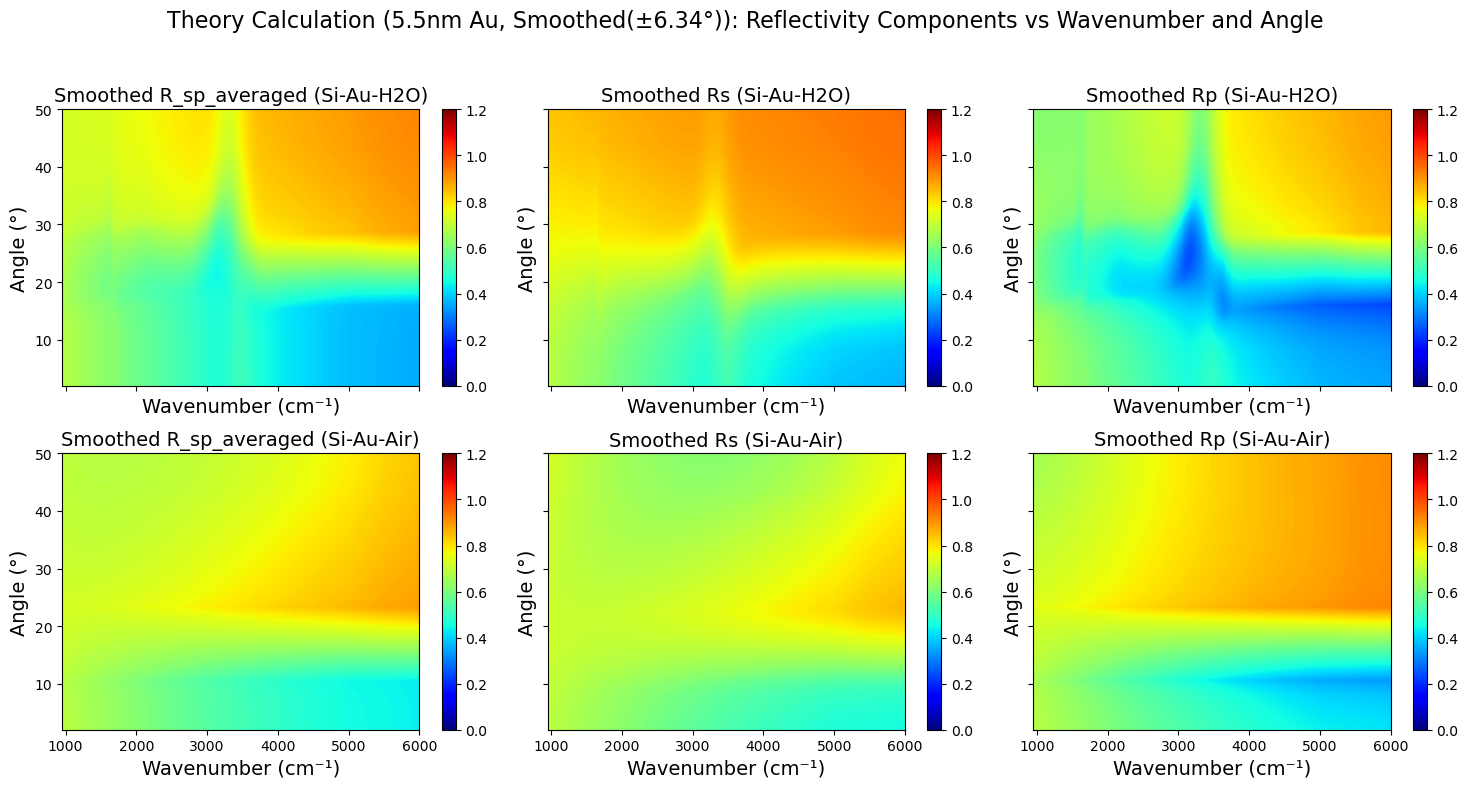

In [18]:
# --- Define smoothed components and subplot titles ---
smoothed_components = [
    R_water_smooth, Rs_water_smooth, Rp_water_smooth,
    R_air_smooth, Rs_air_smooth, Rp_air_smooth
]

titles = [
    "Smoothed R_sp_averaged (Si-Au-H2O)", "Smoothed Rs (Si-Au-H2O)", "Smoothed Rp (Si-Au-H2O)",
    "Smoothed R_sp_averaged (Si-Au-Air)", "Smoothed Rs (Si-Au-Air)", "Smoothed Rp (Si-Au-Air)"
]

# --- Set consistent color levels and ticks ---
levels = np.linspace(0, 1.2, 256)
colorbar_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]

# --- Create 2x3 subplot figure ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

for ax, matrix, title in zip(axes.flat, smoothed_components, titles):
    contour = ax.contourf(W_grid, A_grid, matrix, levels=levels, cmap='jet', extend='neither')
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_ticks(colorbar_ticks)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Wavenumber (cm⁻¹)", fontsize=14)
    ax.set_ylabel("Angle (°)", fontsize=14)
    ax.set_xlim(950, 6000)
    

# --- Final formatting ---
fig.suptitle(f"Theory Calculation ({d_gold*1e9}nm Au, Smoothed(±{window}°)): Reflectivity Components vs Wavenumber and Angle", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


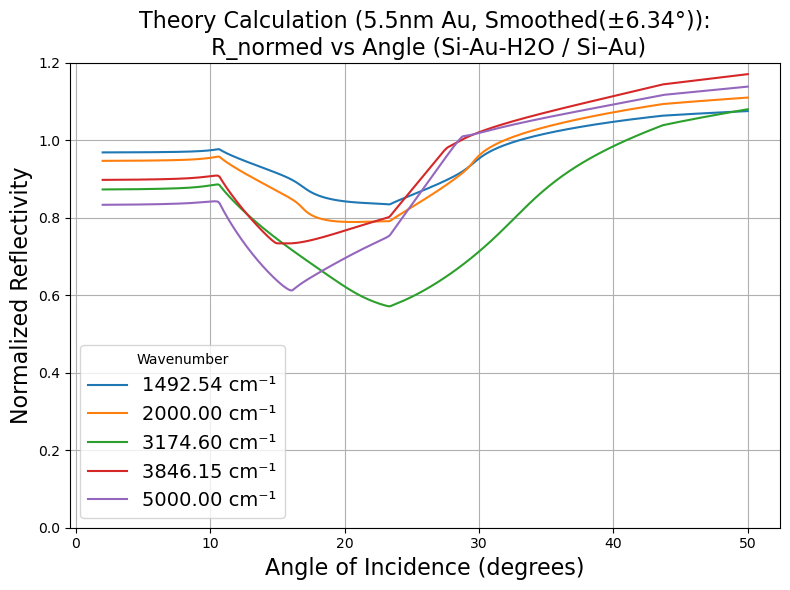

In [19]:
# --- Select target wavenumbers (approximate values) ---
selected_wavenumbers = [1500, 2000, 3200, 4000, 5000]

# Match target wavenumbers to nearest in clipped wavenumber array
matched_wn_indices = [
    np.argmin(np.abs(wavenumbers - wn)) for wn in selected_wavenumbers
]
matched_wn_values = [wavenumbers[i] for i in matched_wn_indices]

# --- Convert to NumPy array if not already ---
Rnorm_smooth = np.array(Rnorm_smooth)

# --- Prepare figure ---
plt.figure(figsize=(8, 6))

# --- Plot Rnorm vs angle for each selected wavenumber ---
for idx, wn in zip(matched_wn_indices, matched_wn_values):
    #Rnorm_curve = Rnorm_smooth[:, idx]
    Rnorm_curve = Rnorm_smooth_ratio[:, idx]
    plt.plot(angles_all, Rnorm_curve, label=f"{wn:.2f} cm⁻¹")

# --- Customize plot ---
plt.title(f"Theory Calculation ({d_gold*1e9}nm Au, Smoothed(±{window}°)):\n R_normed vs Angle (Si-Au-H2O / Si–Au)", fontsize=16)
plt.xlabel("Angle of Incidence (degrees)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(title="Wavenumber", fontsize=14)
plt.tight_layout()
plt.show()



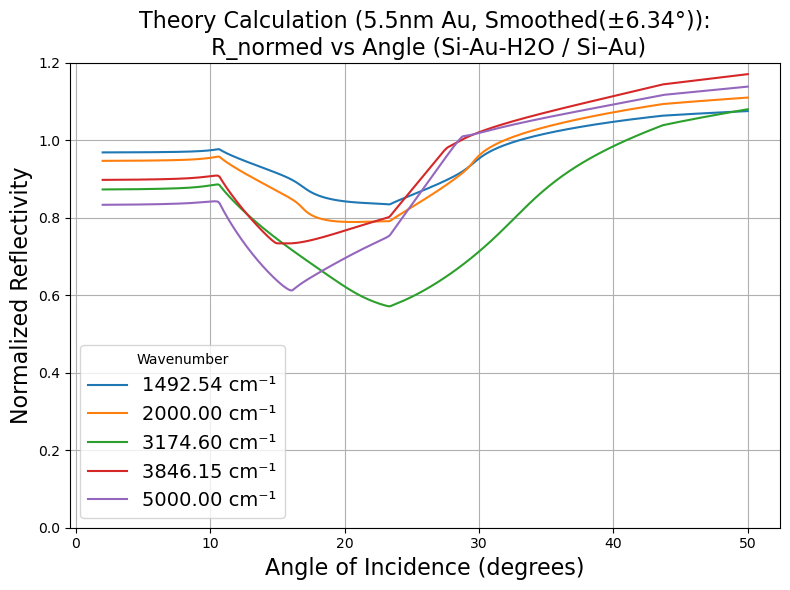

In [20]:
# --- Select target wavenumbers (approximate values) ---
selected_wavenumbers = [1500, 2000, 3200, 4000, 5000]

# Match target wavenumbers to nearest in clipped wavenumber array
matched_wn_indices = [
    np.argmin(np.abs(wavenumbers - wn)) for wn in selected_wavenumbers
]
matched_wn_values = [wavenumbers[i] for i in matched_wn_indices]

# --- Convert to NumPy array if not already ---
Rnorm_smooth = np.array(Rnorm_smooth)

# --- Prepare figure ---
plt.figure(figsize=(8, 6))

# --- Plot Rnorm vs angle for each selected wavenumber ---
for idx, wn in zip(matched_wn_indices, matched_wn_values):
    #Rnorm_curve = Rnorm_smooth[:, idx]
    Rnorm_curve = Rnorm_smooth_ratio[:, idx]
    plt.plot(angles_all, Rnorm_curve, label=f"{wn:.2f} cm⁻¹")

# --- Customize plot ---
plt.title(f"Theory Calculation ({d_gold*1e9}nm Au, Smoothed(±{window}°)):\n R_normed vs Angle (Si-Au-H2O / Si–Au)", fontsize=16)
plt.xlabel("Angle of Incidence (degrees)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(title="Wavenumber", fontsize=14)
plt.tight_layout()
plt.show()



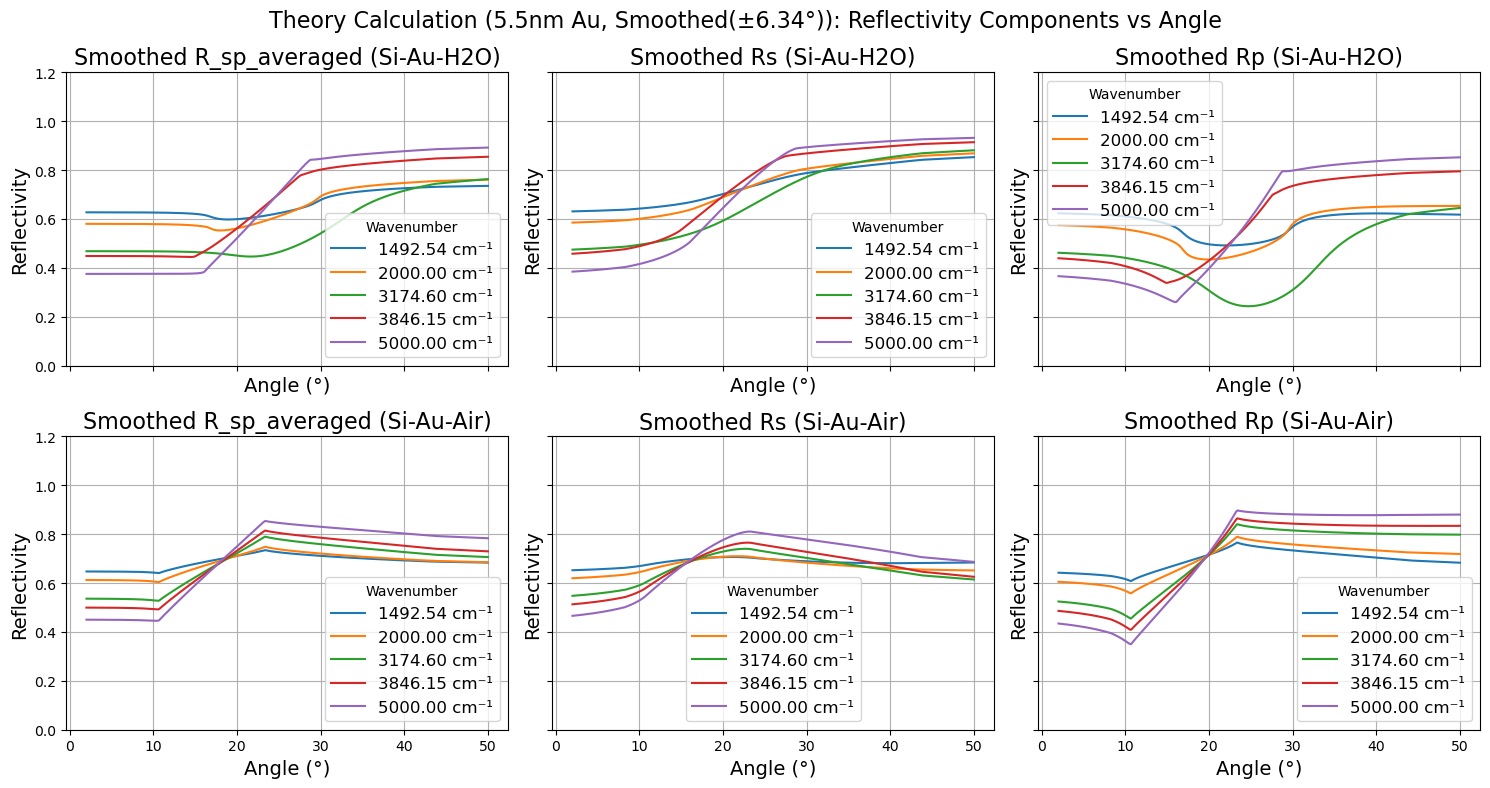

In [21]:
# # --- Define smoothed components and subplot titles ---
# smoothed_components = [
#     R_water_smooth, Rs_water_smooth, Rp_water_smooth,
#     R_air_smooth, Rs_air_smooth, Rp_air_smooth
# ]

titles = [
    "Smoothed R_sp_averaged (Si-Au-H2O)", "Smoothed Rs (Si-Au-H2O)", "Smoothed Rp (Si-Au-H2O)",
    "Smoothed R_sp_averaged (Si-Au-Air)", "Smoothed Rs (Si-Au-Air)", "Smoothed Rp (Si-Au-Air)"
]

# --- Create 2x3 subplot figure ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

# --- Loop over each subplot and plot angle-resolved curves ---
for ax, matrix, title in zip(axes.flat, smoothed_components, titles):
    for idx, wn in zip(matched_wn_indices, matched_wn_values):
        curve = matrix[:, idx]
        ax.plot(angles_all, curve, label=f"{wn:.2f} cm⁻¹")
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Angle (°)", fontsize=14)
    ax.set_ylabel("Reflectivity", fontsize=14)
    ax.set_ylim(0, 1.2)
    ax.grid(True)
    ax.legend(title="Wavenumber", fontsize=12)

# --- Final formatting ---
fig.suptitle(f"Theory Calculation ({d_gold*1e9}nm Au, Smoothed(±{window}°)): Reflectivity Components vs Angle", fontsize=16)
plt.tight_layout()
plt.show()


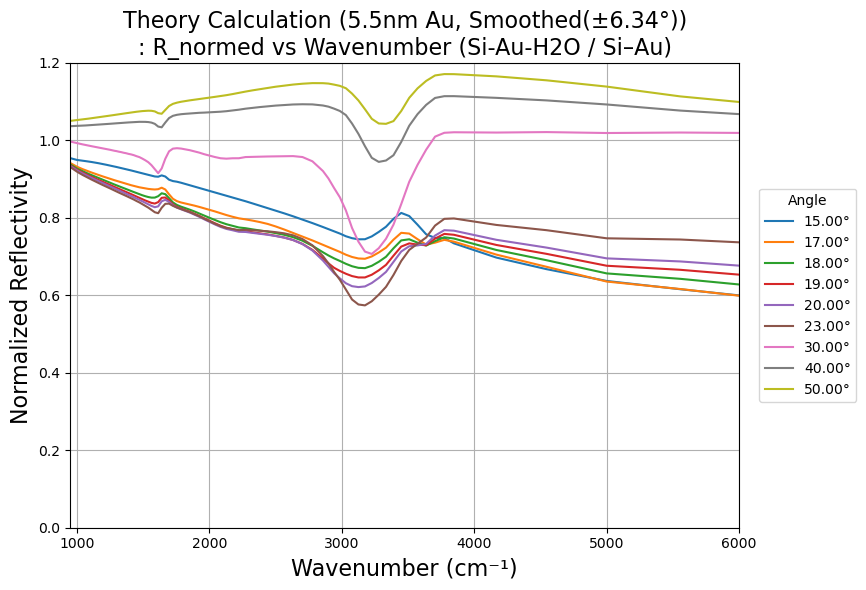

In [22]:
# --- Select target angles (in degrees) ---
#target_angles = [22.2, 22.7, 23.3, 24.4, 25.6,33.5]     # Approximate, match to available ones
target_angles = [15, 17,18, 19,20, 23, 30, 40, 50] 
# Match to closest available angles
matched_angle_indices = [np.argmin(np.abs(angles_all - a)) for a in target_angles]
matched_angle_values = [angles_all[i] for i in matched_angle_indices]

# --- Plot ---
plt.figure(figsize=(11, 6))

for idx, angle in zip(matched_angle_indices, matched_angle_values):
    #Rnorm_curve = Rnorm_smooth[idx, :]
    Rnorm_curve = Rnorm_smooth_ratio[idx, :]
    plt.plot(wavenumbers, Rnorm_curve, label=f"{angle:.2f}°")

# --- Customize plot ---
plt.title(f"Theory Calculation ({d_gold*1e9}nm Au, Smoothed(±{window}°))\n: R_normed vs Wavenumber (Si-Au-H2O / Si–Au)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.xlim(950, 6000)
plt.ylim(0, 1.2)
plt.grid(True)
# Place legend outside
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend

plt.show()



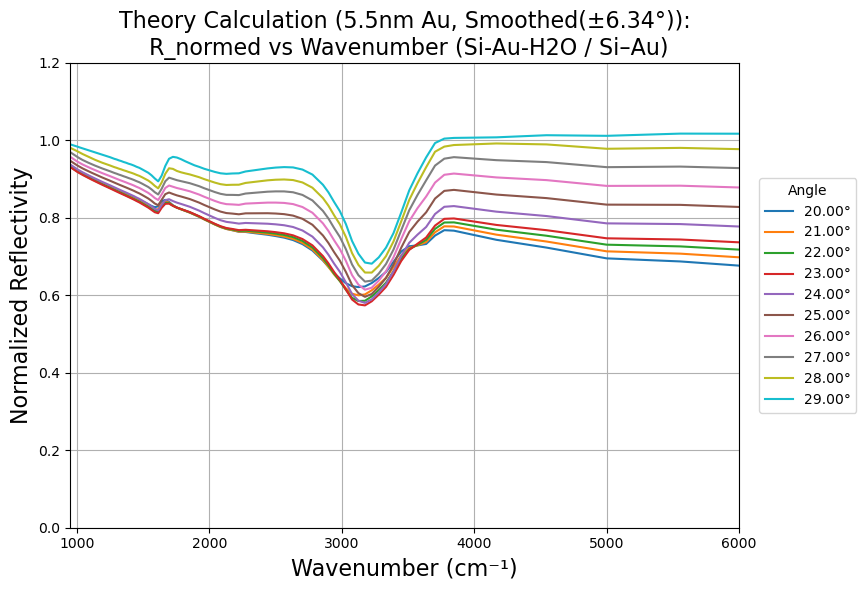

In [23]:
# --- Select target angles (in degrees) ---
target_angles = [20,21,22,23,24,25,26,27,28,29]
# Match to closest available angles
matched_angle_indices = [np.argmin(np.abs(angles_all - a)) for a in target_angles]
matched_angle_values = [angles_all[i] for i in matched_angle_indices]

# --- Plot ---
plt.figure(figsize=(11, 6))

for idx, angle in zip(matched_angle_indices, matched_angle_values):
    #Rnorm_curve = Rnorm_smooth[idx, :]
    Rnorm_curve = Rnorm_smooth_ratio[idx, :]
    plt.plot(wavenumbers, Rnorm_curve, label=f"{angle:.2f}°")

# --- Customize plot ---
plt.title(f"Theory Calculation ({d_gold*1e9}nm Au, Smoothed(±{window}°)):\n R_normed vs Wavenumber (Si-Au-H2O / Si–Au)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.xlim(950, 6000)
plt.ylim(0, 1.2)
plt.grid(True)
# Place legend outside
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend

plt.show()



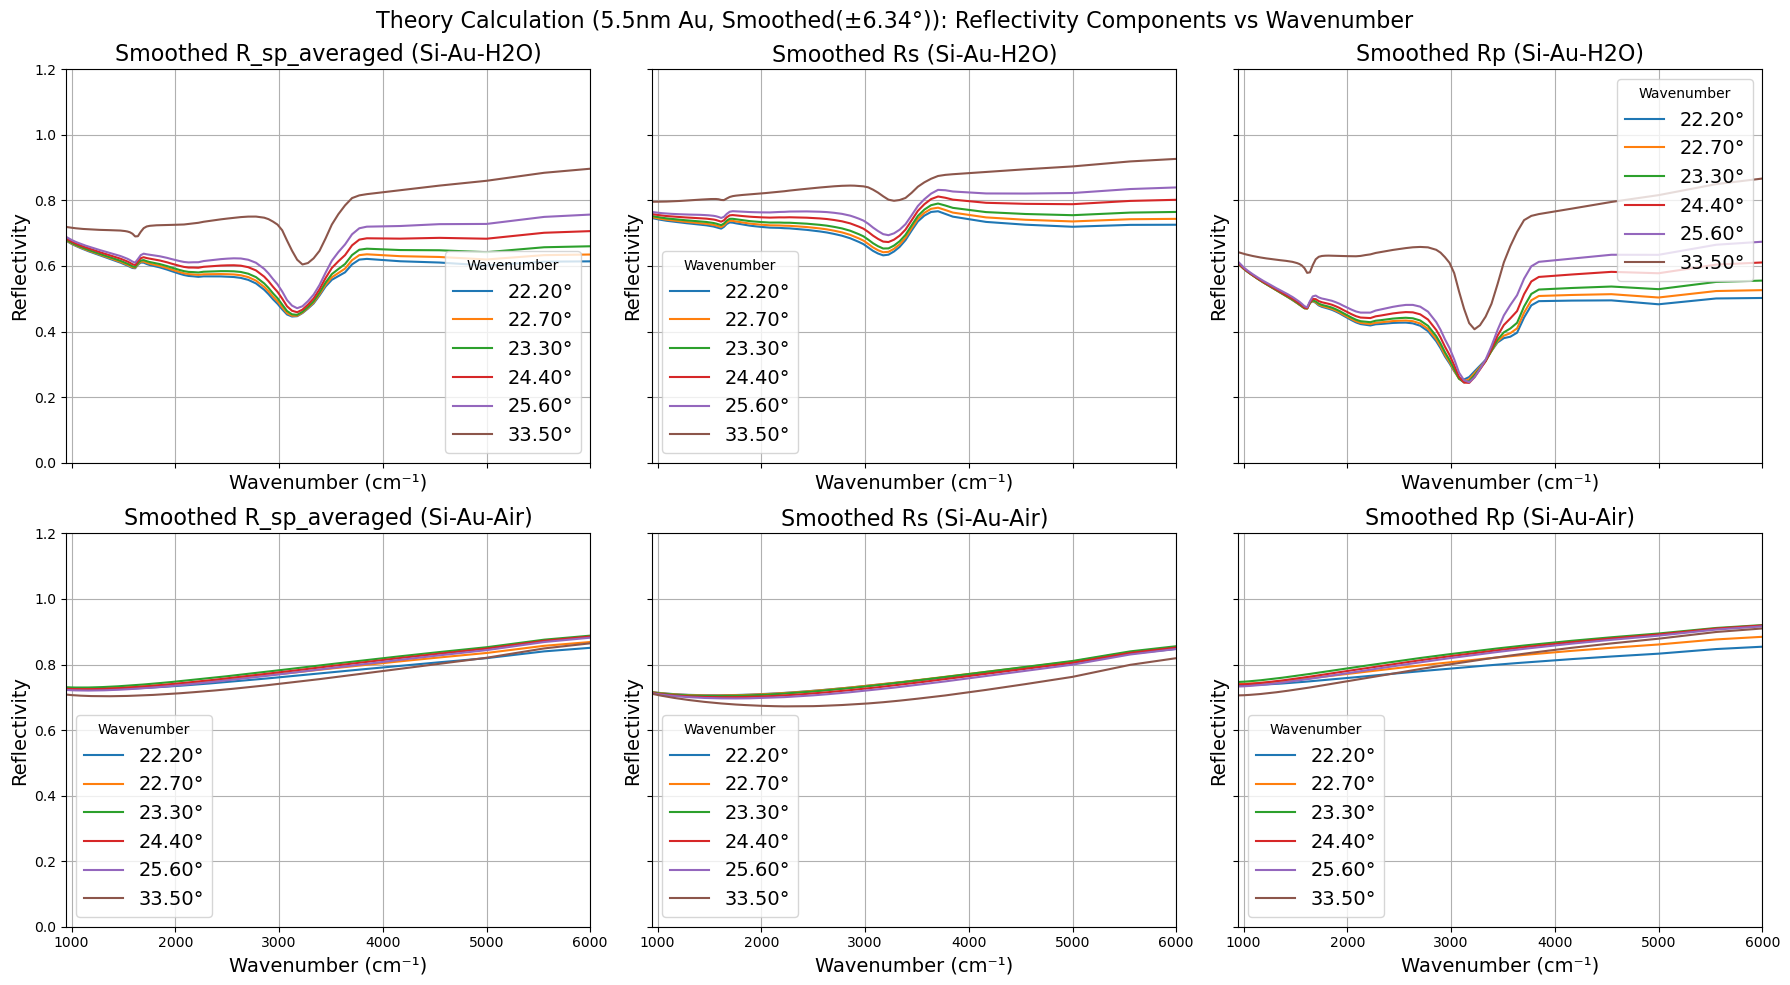

In [24]:

titles = [
    "Smoothed R_sp_averaged (Si-Au-H2O)", "Smoothed Rs (Si-Au-H2O)", "Smoothed Rp (Si-Au-H2O)",
    "Smoothed R_sp_averaged (Si-Au-Air)", "Smoothed Rs (Si-Au-Air)", "Smoothed Rp (Si-Au-Air)"
]

# --- Define angles for curves (reuse target_angles logic) ---
target_angles = [22.2, 22.7, 23.3, 24.4, 25.6, 33.5]
available_angles = angles_all
matched_angles = [available_angles[np.argmin(np.abs(available_angles - a))] for a in target_angles]
matched_indices = [np.where(angles_all == a)[0][0] for a in matched_angles]

# --- Create 2x3 subplot figure ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# --- Plot each subplot ---
for ax, matrix, title in zip(axes.flat, smoothed_components, titles):
    for idx, angle in zip(matched_indices, matched_angles):
        curve = matrix[idx, :]
        ax.plot(wavenumbers, curve, label=f"{angle:.2f}°")
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Wavenumber (cm⁻¹)", fontsize=14)
    ax.set_ylabel("Reflectivity", fontsize=14)
    ax.set_xlim(950, 6000)
    ax.set_ylim(0, 1.2)
    ax.grid(True)
    ax.legend(title="Wavenumber", fontsize=14)

# --- Final formatting ---
fig.suptitle(f"Theory Calculation ({d_gold*1e9}nm Au, Smoothed(±{window}°)): Reflectivity Components vs Wavenumber", fontsize=16)
plt.tight_layout()
plt.show()
